# NoiseDetective: Image Noise Analysis and Removal Tool

This notebook demonstrates analyzing and mitigating common types of image noise.
We will:
1. Load a sample image.
2. Add Gaussian and Salt & Pepper noise.
3. Apply various denoising filters (Gaussian Blur, Median, Non-Local Means).
4. Evaluate filter performance using PSNR and SSIM.
5. Visualize results (histograms, metric comparisons).

## 1. Imports and Setup

In [1]:
import os
from pathlib import Path
import time
from typing import Tuple, Dict, Any

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from skimage import data, img_as_float
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.util import random_noise
from skimage.restoration import denoise_nl_means, estimate_sigma

In [3]:
%matplotlib inline
sns.set_theme(style="whitegrid")

In [4]:
# --- Configuration Flags ---
# Set to True to load 'sample.*' from root, False to use skimage.data.astronaut()
USE_CUSTOM_IMAGE = True
CUSTOM_IMAGE_NAME = "sample.jpg" # Change to your image name (e.g., "sample.png")

# Set to True if you want to *add* synthetic noise to the loaded image.
# Set to False if your loaded image *already* contains noise you want to remove.
ADD_NOISE = True # <<< CHANGE THIS BASED ON YOUR NEED

# If ADD_NOISE is True, set noise parameters:
NOISE_VAR_GAUSSIAN = 0.01 # Variance for Gaussian noise
NOISE_AMOUNT_SP = 0.05 # Proportion for S&P noise

# Directory for saving final denoised images
OUTPUT_DIR = Path("../output_images")
OUTPUT_DIR.mkdir(exist_ok=True)
# --- End Configuration ---

# Define output directory for figures (already exists)
FIGURES_DIR = Path("../figures")
FIGURES_DIR.mkdir(exist_ok=True)

## 2. Helper Functions

Define functions for noise addition, filtering, metrics, and plotting.

### Noise Addition

In [5]:
def add_gaussian_noise(
    image: np.ndarray, var: float = 0.01
) -> np.ndarray:
    """Adds Gaussian noise to an image."""
    return random_noise(image, mode="gaussian", var=var, clip=True)

In [6]:
def add_salt_pepper_noise(
    image: np.ndarray, amount: float = 0.05
) -> np.ndarray:
    """Adds Salt & Pepper noise to an image."""
    return random_noise(image, mode="s&p", amount=amount, clip=True)

### Denoising Filters

In [7]:
def apply_gaussian_blur(
    image: np.ndarray, ksize: Tuple[int, int] = (5, 5)
) -> np.ndarray:
    """Applies Gaussian Blur filter."""
    # OpenCV works with 0-255 range typically
    if image.dtype == np.float64 or image.dtype == np.float32:
        image_uint8 = (image * 255).astype(np.uint8)
    else:
        image_uint8 = image
    denoised = cv2.GaussianBlur(image_uint8, ksize, 0)
    return img_as_float(denoised)

In [8]:
def apply_median_filter(image: np.ndarray, ksize: int = 5) -> np.ndarray:
    """Applies Median filter."""
    if image.dtype == np.float64 or image.dtype == np.float32:
        image_uint8 = (image * 255).astype(np.uint8)
    else:
        image_uint8 = image
    # Ensure ksize is odd
    ksize = ksize if ksize % 2 != 0 else ksize + 1
    denoised = cv2.medianBlur(image_uint8, ksize)
    return img_as_float(denoised)

In [9]:
def apply_nl_means(
    image: np.ndarray, h_factor: float = 1.15
) -> np.ndarray:
    """Applies Non-Local Means denoising."""
    # Estimate noise standard deviation
    sigma_est = np.mean(estimate_sigma(image, channel_axis=-1))

    # Apply NLM
    # patch_size and patch_distance are important parameters
    # h = h_factor * sigma_est controls filter strength
    denoised = denoise_nl_means(
        image,
        h=h_factor * sigma_est,
        fast_mode=True,
        patch_size=5,
        patch_distance=6,
        channel_axis=-1,
    )
    return denoised

### Evaluation Metrics

In [10]:
def calculate_metrics(
    original: np.ndarray, processed: np.ndarray
) -> Dict[str, float]:
    """Calculates PSNR and SSIM between two images."""
    data_range = original.max() - original.min()
    psnr_val = psnr(original, processed, data_range=data_range)
    
    # Ensure SSIM calculation handles multichannel correctly
    channel_axis = -1 if original.ndim == 3 else None
    ssim_val = ssim(
        original, 
        processed, 
        data_range=data_range, 
        channel_axis=channel_axis
    )
    return {"PSNR": psnr_val, "SSIM": ssim_val}

### Plotting Functions

In [11]:
def plot_image_comparison(
    images: Dict[str, np.ndarray], title: str, filename: Path
) -> None:
    """Plots multiple images side-by-side."""
    n_images = len(images)
    fig, axes = plt.subplots(
        1, n_images, figsize=(5 * n_images, 5), sharex=True, sharey=True
    )
    if n_images == 1: # Handle case with single image
        axes = [axes]
    
    for ax, (label, img) in zip(axes, images.items()):
        cmap = "gray" if img.ndim == 2 else None
        ax.imshow(img, cmap=cmap)
        ax.set_title(label)
        ax.axis("off")
    fig.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout for suptitle
    plt.savefig(filename)
    print(f"Saved comparison plot: {filename}")
    plt.show()

In [12]:
def plot_histograms(
    images: Dict[str, np.ndarray], title: str, filename: Path
) -> None:
    """Plots histograms for multiple images."""
    fig, ax = plt.subplots(figsize=(10, 6))
    for label, img in images.items():
        # Use ravel to flatten the image array for histogram calculation
        sns.histplot(img.ravel(), kde=False, label=label, ax=ax, stat="density", common_norm=False, bins=50)
    ax.set_title(title)
    ax.set_xlabel("Pixel Intensity")
    ax.set_ylabel("Density")
    ax.legend()
    plt.tight_layout()
    plt.savefig(filename)
    print(f"Saved histogram plot: {filename}")
    plt.show()

In [13]:
def plot_metrics_comparison(
    metrics_df: pd.DataFrame, title: str, filename: Path
) -> None:
    """Plots PSNR and SSIM comparison using a bar chart."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # PSNR Plot
    sns.barplot(x=metrics_df.index, y="PSNR", data=metrics_df, ax=axes[0], palette="viridis")
    axes[0].set_title("PSNR Comparison (Higher is Better)")
    axes[0].set_ylabel("PSNR (dB)")
    axes[0].tick_params(axis='x', rotation=45)

    # SSIM Plot
    sns.barplot(x=metrics_df.index, y="SSIM", data=metrics_df, ax=axes[1], palette="viridis")
    axes[1].set_title("SSIM Comparison (Higher is Better)")
    axes[1].set_ylabel("SSIM")
    axes[1].tick_params(axis='x', rotation=45)

    fig.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(filename)
    print(f"Saved metrics plot: {filename}")
    plt.show()

## 3. Load Sample Image

Load a standard grayscale or color image. Using `skimage.data`.

In [14]:
# ## 3. Load Image

from skimage import io # Make sure io is imported

if USE_CUSTOM_IMAGE:
    # Construct path relative to the notebook location
    image_path = Path(f"../{CUSTOM_IMAGE_NAME}")
    print(f"Attempting to load custom image from: {image_path}")
    try:
        image_original_rgb = io.imread(image_path)
        # Handle RGBA by removing alpha
        if image_original_rgb.ndim == 3 and image_original_rgb.shape[2] == 4:
             image_original_rgb = image_original_rgb[:, :, :3]
             print("Loaded RGBA image, removed alpha channel.")
        # Convert to float
        image_original_float = img_as_float(image_original_rgb)
        print(f"Successfully loaded custom image: {CUSTOM_IMAGE_NAME}")
    except FileNotFoundError:
        print(f"ERROR: Custom image not found at {image_path}")
        print("Please place the image in the root project folder.")
        # Optional: Stop execution or fallback to default
        # raise FileNotFoundError(f"Could not load image: {image_path}")
        print("Falling back to default skimage image.")
        image_original_rgb = data.astronaut()
        image_original_float = img_as_float(image_original_rgb)

else:
    print("Using default skimage image (astronaut).")
    image_original_rgb = data.astronaut()
    image_original_float = img_as_float(image_original_rgb)
    

# Store the initially loaded image (could be clean or already noisy)
image_loaded = image_original_float.copy()

# This will be our "ground truth" only if we add noise synthetically
image_clean_reference = image_loaded.copy() if ADD_NOISE else None

Attempting to load custom image from: ..\sample.jpg
Successfully loaded custom image: sample.jpg


In [15]:
print(f"Loaded image shape: {image_original_float.shape}, dtype: {image_original_float.dtype}")

Loaded image shape: (2990, 2990, 3), dtype: float64


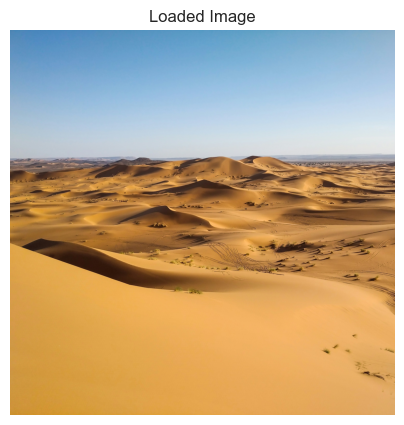

In [16]:
# Display the loaded image
plt.figure(figsize=(5, 5))
cmap_val = 'gray' if image_loaded.ndim == 2 else None
plt.imshow(image_loaded, cmap=cmap_val)
plt.title("Loaded Image")
plt.axis("off")
plt.show()

## 4. Add Noise

We will simulate adding Gaussian and Salt & Pepper noise.

Adding synthetic noise...
Saved comparison plot: ..\figures\synthetic_noisy_images_comparison.png


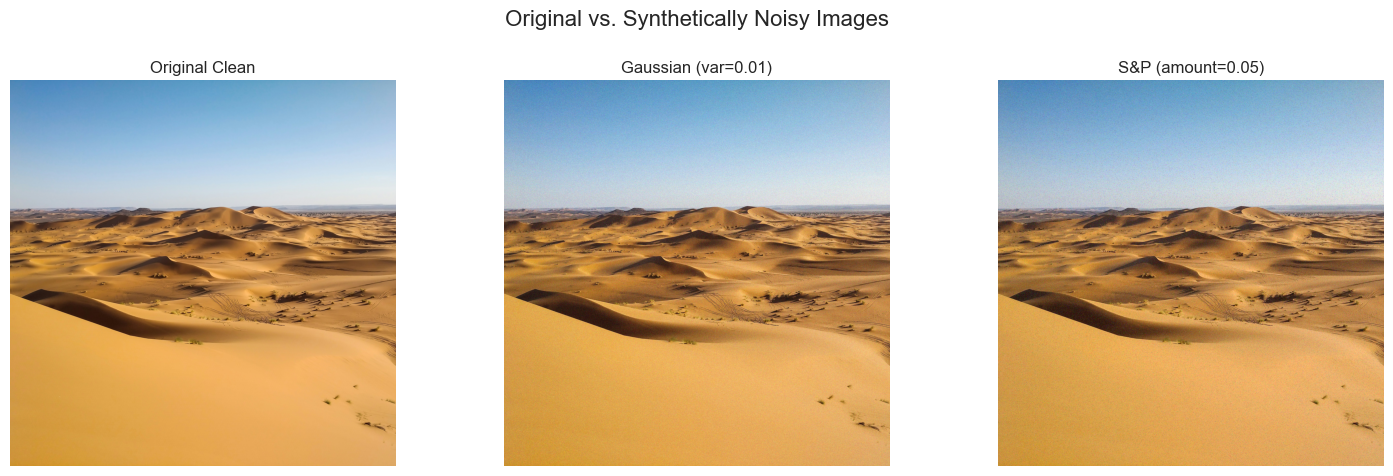

Noise addition took: 10.54 seconds
Proceeding to denoise the image with Synthetic Gaussian Noise.


In [17]:
# ## 4. Add Noise (Optional)

noisy_gaussian = None
noisy_sp = None

if ADD_NOISE:
    print("Adding synthetic noise...")
    start_time = time.time()

    # Use noise parameters from config
    noisy_gaussian = add_gaussian_noise(image_loaded, var=NOISE_VAR_GAUSSIAN)
    noisy_sp = add_salt_pepper_noise(image_loaded, amount=NOISE_AMOUNT_SP)

    # Display noisy images comparison (only if noise was added)
    plot_image_comparison(
        {"Original Clean": image_loaded,
         f"Gaussian (var={NOISE_VAR_GAUSSIAN})": noisy_gaussian,
         f"S&P (amount={NOISE_AMOUNT_SP})": noisy_sp},
        title="Original vs. Synthetically Noisy Images",
        filename=FIGURES_DIR / "synthetic_noisy_images_comparison.png"
    )

    print(f"Noise addition took: {time.time() - start_time:.2f} seconds")

    # In this case, we choose ONE type of noisy image to proceed with denoising
    # Let's choose Gaussian for this example, you can change this
    image_to_denoise = noisy_gaussian
    noise_type_label = "Synthetic Gaussian Noise"
    print(f"Proceeding to denoise the image with {noise_type_label}.")

else:
    print("Skipping synthetic noise addition.")
    print("Assuming the loaded image is the noisy input.")
    image_to_denoise = image_loaded # The loaded image is the one to denoise
    noise_type_label = "Input Image"

# Ensure image_to_denoise is not None
if image_to_denoise is None:
    raise ValueError("Image to denoise is not set. Check logic.")

## 5. Apply Denoising Filters

Apply Gaussian Blur, Median Filter, and Non-Local Means to both types of noisy images.

Applying denoising filters to: Synthetic Gaussian Noise
Denoising took: 18.10 seconds
Saved comparison plot: ..\figures\denoising_results_comparison.png


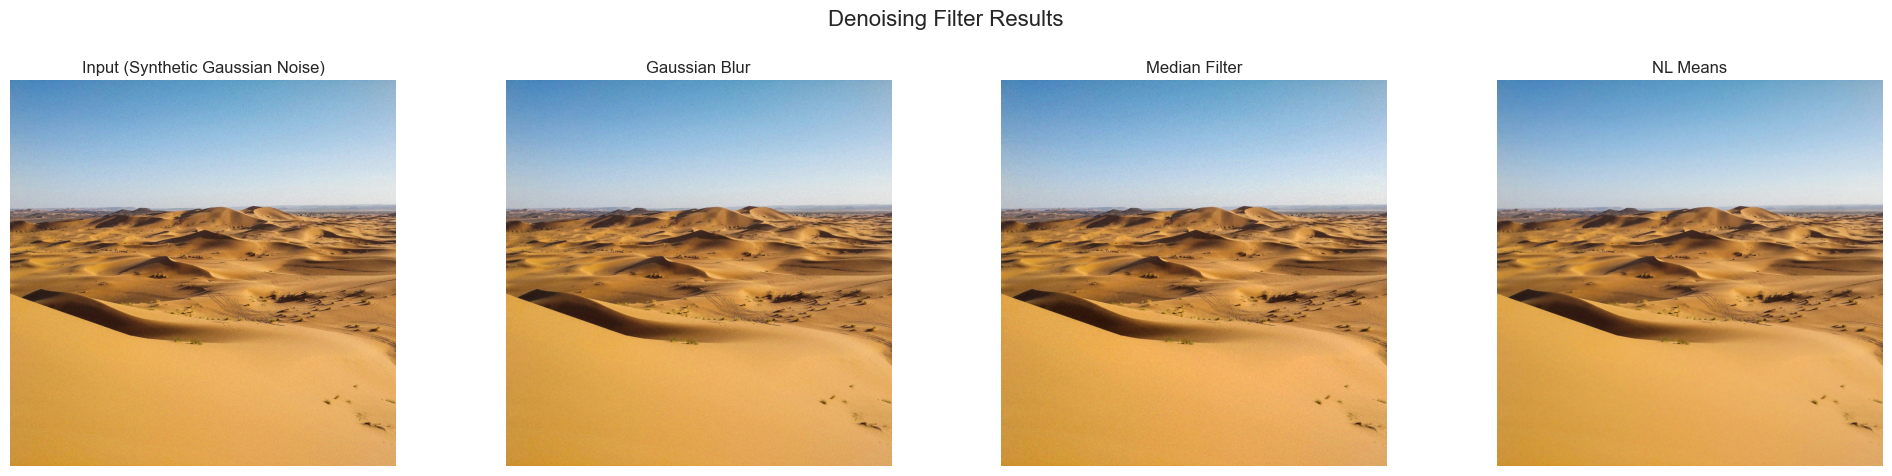

In [18]:
# ## 5. Apply Denoising Filters

print(f"Applying denoising filters to: {noise_type_label}")
start_time = time.time()

# Apply filters to the input image (which might be synthetically noisy or the original loaded image)
denoised_blur = apply_gaussian_blur(image_to_denoise)
denoised_median = apply_median_filter(image_to_denoise)
denoised_nlm = apply_nl_means(image_to_denoise)

print(f"Denoising took: {time.time() - start_time:.2f} seconds")

# Store results
denoising_results = {
    "Gaussian Blur": denoised_blur,
    "Median Filter": denoised_median,
    "NL Means": denoised_nlm,
}

# Display denoising results comparison
plot_image_comparison(
    {
        f"Input ({noise_type_label})": image_to_denoise,
        "Gaussian Blur": denoised_blur,
        "Median Filter": denoised_median,
        "NL Means": denoised_nlm,
    },
    title="Denoising Filter Results",
    filename=FIGURES_DIR / "denoising_results_comparison.png"
)

## 6. Evaluate Performance

Calculate PSNR and SSIM for each denoised image compared to the original.

In [19]:
# ## 6. Evaluate Performance (Optional)

metrics_results = []
metrics_df = None

if ADD_NOISE and image_clean_reference is not None:
    print("Evaluating filter performance using PSNR & SSIM (compared to original clean image)...")
    for name, img_denoised in denoising_results.items():
        metrics = calculate_metrics(image_clean_reference, img_denoised)
        metrics["Filter"] = name
        metrics["Noise Type"] = noise_type_label # Label based on added noise
        metrics_results.append(metrics)
        print(f"  - {name}: PSNR={metrics['PSNR']:.2f} dB, SSIM={metrics['SSIM']:.3f}")

    # Convert results to DataFrame
    metrics_df = pd.DataFrame(metrics_results)
    print("\n--- Performance Metrics Summary ---")
    print(metrics_df)

else:
    print("Skipping PSNR/SSIM calculation because no synthetic noise was added (no clean reference).")

Evaluating filter performance using PSNR & SSIM (compared to original clean image)...
  - Gaussian Blur: PSNR=29.90 dB, SSIM=0.654
  - Median Filter: PSNR=29.24 dB, SSIM=0.676
  - NL Means: PSNR=33.58 dB, SSIM=0.926

--- Performance Metrics Summary ---
        PSNR      SSIM         Filter                Noise Type
0  29.901281  0.654420  Gaussian Blur  Synthetic Gaussian Noise
1  29.236649  0.676078  Median Filter  Synthetic Gaussian Noise
2  33.575663  0.925680       NL Means  Synthetic Gaussian Noise


## 7. Visualize Results

In [ ]:
# ## 7. Visualize Results

# ### Plot 1: Histogram Comparison
# Compare histograms of the input image and the denoised images.
print("Generating histogram comparison plot...")
histogram_images = {f"Input ({noise_type_label})": image_to_denoise}
histogram_images.update({f"Denoised ({name})": img for name, img in denoising_results.items()})

plot_histograms(
    histogram_images,
    title="Pixel Intensity Distribution Comparison",
    filename=FIGURES_DIR / "histogram_comparison.png" # Overwrite previous histogram plot
)

# ### Plot 2: Metrics Comparison Bar Chart (Conditional)
if metrics_df is not None:
    print("Generating metrics comparison plot...")
    plot_metrics_comparison(
        metrics_df.set_index("Filter"),
        title="Denoising Filter Performance Comparison",
        filename=FIGURES_DIR / "metrics_comparison.png" # Overwrite previous metrics plot
    )
else:
    print("Skipping metrics comparison plot (no metrics calculated).")

Generating histogram comparison plot...


In [ ]:
# ## 8. Save Denoised Images

from skimage.util import img_as_ubyte # To convert float [0,1] to uint8 [0,255] for saving

print(f"Saving denoised images to: {OUTPUT_DIR}")

# Determine base filename from input
base_filename = Path(CUSTOM_IMAGE_NAME).stem if USE_CUSTOM_IMAGE else "astronaut"

for name, img_denoised in denoising_results.items():
    # Format filter name for filename (e.g., "Gaussian Blur" -> "gaussian_blur")
    filter_fname = name.lower().replace(" ", "_")
    output_fname = f"{base_filename}_denoised_{filter_fname}.png"
    output_path = OUTPUT_DIR / output_fname

    # Save the image - convert back to uint8 for standard image formats
    try:
        io.imsave(output_path, img_as_ubyte(img_denoised))
        print(f"  - Saved: {output_path}")
    except Exception as e:
        print(f"  - Failed to save {output_path}: {e}")


print("\n--- Notebook Execution Complete ---")